In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import os

In [2]:
os.chdir('/home/jovyan/EY-Crop-identification')
print(os.getcwd())

/home/jovyan/EY-Crop-identification


# Define functions

In [16]:
def read_vhvv(dir, train=True):
    """Read VH/VV data from files in the given directory."""
    num_file = 600 if train else 250
    sen1 = []
    for i in range(num_file):
        data = xr.open_dataset(os.path.join(dir, f"vhvv_row{i}.nc"))
        sen1.append(data)
    return sen1

def read_sen2(dir, train=True):
    """Read Sentinel-2 data from files in the given directory."""
    num_file = 600 if train else 250
    sen2 = []
    for i in range(num_file):
        data = xr.open_dataset(os.path.join(dir, f"vhvv_sen2_row{i}.nc"))
        sen2.append(data)
    return sen2

def replace_outliers_with_mean(arr):
    """Replace the outliers in the array with the mean of the non-outlier elements."""
    # Calculate the first and third quartile and interquartile range
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify the outliers
    outliers = (arr < lower_bound) | (arr > upper_bound)

    # Calculate the mean of the non-outlier elements
    mean_non_outliers = np.mean(arr[~outliers])

    # Replace the outliers with the mean of non-outliers
    arr[outliers] = mean_non_outliers

    return arr

def viz_sen1(sen1):
    """Calculate RVI, mean VV, and mean VH for the given Sentinel-1 data."""
    # Compute the mean
    mean = sen1.mean(dim=['x', 'y']).compute()
    dop = (mean.vv / (mean.vv + mean.vh))
    rvi = (np.sqrt(dop)) * ((4 * mean.vh) / (mean.vv + mean.vh))
    return rvi, mean.vv, mean.vh

def viz_sen2(sen2):
    """Calculate NDVI, SAVI, NDWI, and EVI for the given Sentinel-2 data."""
    # Constants for the EVI calculation
    L = 1
    C1 = 6
    C2 = 7.5
    G = 2.5

    # Compute the mean
    mean_unfiltered = sen2.mean(dim=['longitude','latitude']).compute()
    ndvi_mean = (mean_unfiltered.nir-mean_unfiltered.red)/(mean_unfiltered.nir+mean_unfiltered.red)
    savi_mean = (1+0.5) * (mean_unfiltered.nir - mean_unfiltered.red)/(mean_unfiltered.nir + mean_unfiltered.red + 0.5)
    ndwi_mean = (mean_unfiltered.green - mean_unfiltered.nir) / (mean_unfiltered.green + mean_unfiltered.nir)
    evi_mean = G*((mean_unfiltered.nir-mean_unfiltered.red)/(mean_unfiltered.nir+C1*mean_unfiltered.red-C2*mean_unfiltered.blue+L))
    gci_mean = (mean_unfiltered.green - mean_unfiltered.red) / (mean_unfiltered.green + mean_unfiltered.red)
    lai_mean = np.exp(3.618 + 0.0037 * ndvi_mean)
    return ndvi_mean, savi_mean, ndwi_mean, evi_mean, gci_mean, lai_mean

def plot_time_series(crop_presence_data, column_name, title, ylabel):
    """Plot the time series data for the given DataFrame and column."""
    fig = plt.figure(figsize=(10, 5))

    # Plot the data
    for i in range(len(crop_presence_data)):
        color = 'red' if crop_presence_data["Class of Land"][i] == 'Rice' else 'blue'
        crop_presence_data[column_name][i].plot(color=color, alpha=0.1, label=crop_presence_data["Class of Land"][i])

    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.show()

# Load data

In [11]:
crop_presence_data = pd.read_csv("Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [12]:
sen1 = read_vhvv("Data/vhvv/train")
sen2 = read_sen2("Data/vhvv/train")

# Replace outlier with value mean

In [13]:
# Replace outliers in Sentinel-1 data with mean of non-outliers
for i in range(len(sen1)):
    sen1[i]['vv'].values = replace_outliers_with_mean(sen1[i]['vv'].values)
    sen1[i]['vh'].values = replace_outliers_with_mean(sen1[i]['vh'].values)

# Replace outliers in Sentinel-2 data with mean of non-outliers
for i in range(len(sen2)):
    sen2[i]['red'].values = replace_outliers_with_mean(sen2[i]['red'].values)
    sen2[i]['green'].values = replace_outliers_with_mean(sen2[i]['green'].values)
    sen2[i]['blue'].values = replace_outliers_with_mean(sen2[i]['blue'].values)
    sen2[i]['nir'].values = replace_outliers_with_mean(sen2[i]['nir'].values)
    sen2[i]['SCL'].values = replace_outliers_with_mean(sen2[i]['SCL'].values)

In [18]:
# Calculate indices for Sentinel-1 data
rvi_list, vv_list, vh_list = [], [], []
for i in range(len(sen1)):
    rvi_value, vv_value, vh_value = viz_sen1(sen1[i])
    rvi_list.append(rvi_value)
    vv_list.append(vv_value)
    vh_list.append(vh_value)

# Calculate indices for Sentinel-2 data
ndvi_list, savi_list, ndwi_list, evi_list, gci_list, lai_list = [], [], [], [], [], []
for i in range(len(sen2)):
    ndvi_value, savi_value, ndwi_value, evi_value, gci_value, lai_value = viz_sen2(sen2[i])
    ndvi_list.append(ndvi_value)
    savi_list.append(savi_value)
    ndwi_list.append(ndwi_value)
    evi_list.append(evi_value)
    gci_list.append(gci_value)
    lai_list.append(lai_value)

# Add calculated indices to the DataFrame
crop_presence_data['ndvi'] = ndvi_list
crop_presence_data['savi'] = savi_list
crop_presence_data['ndwi'] = ndwi_list
crop_presence_data['evi'] = evi_list
crop_presence_data['rvi'] = rvi_list
crop_presence_data['gci'] = gci_list
crop_presence_data['lai'] = lai_list
crop_presence_data['vv'] = vv_list
crop_presence_data['vh'] = vh_list


# Visualize generated indexes

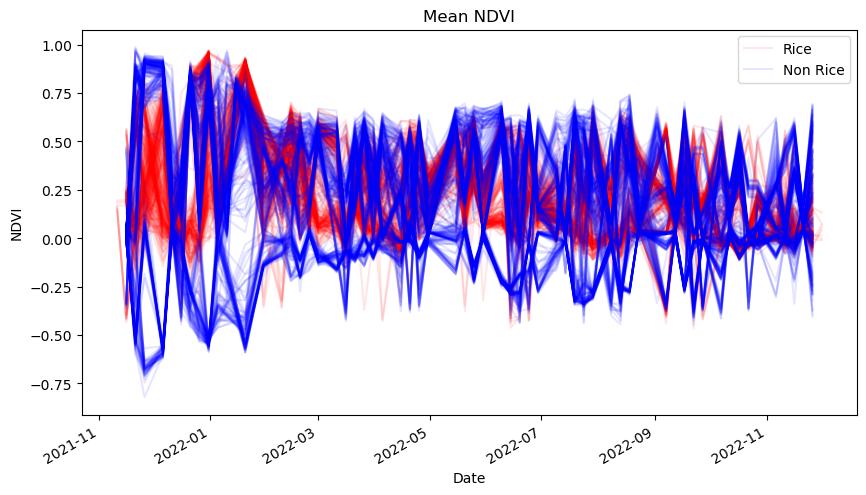

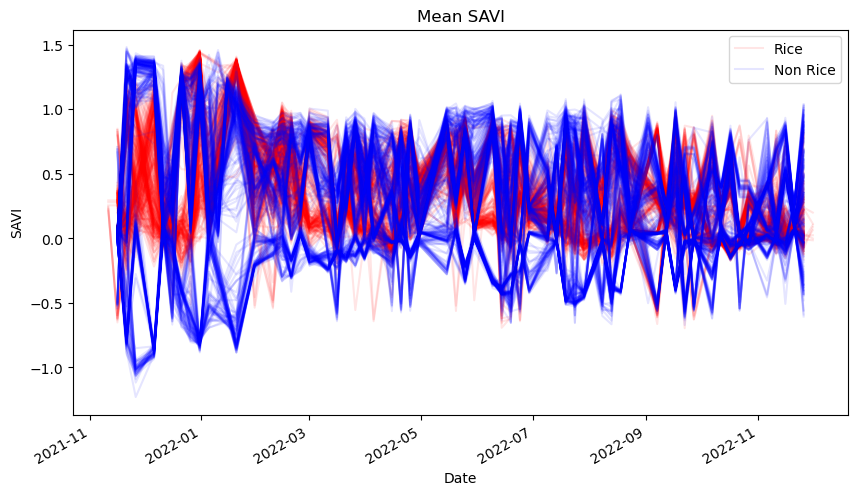

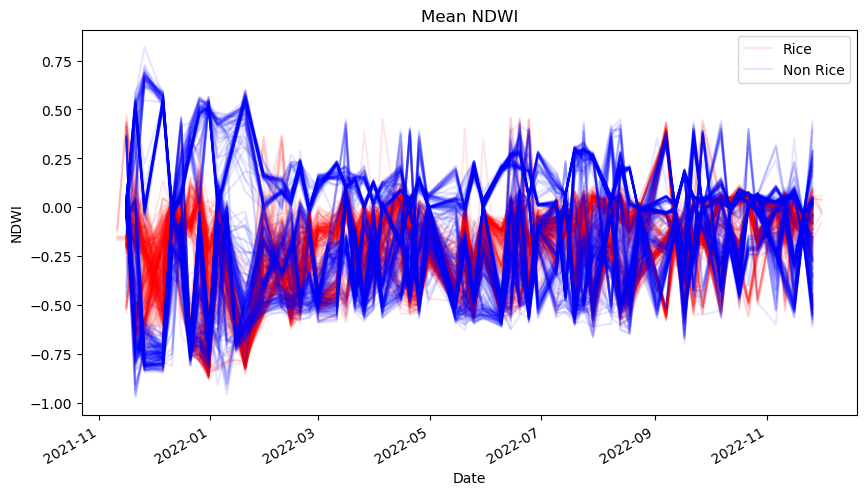

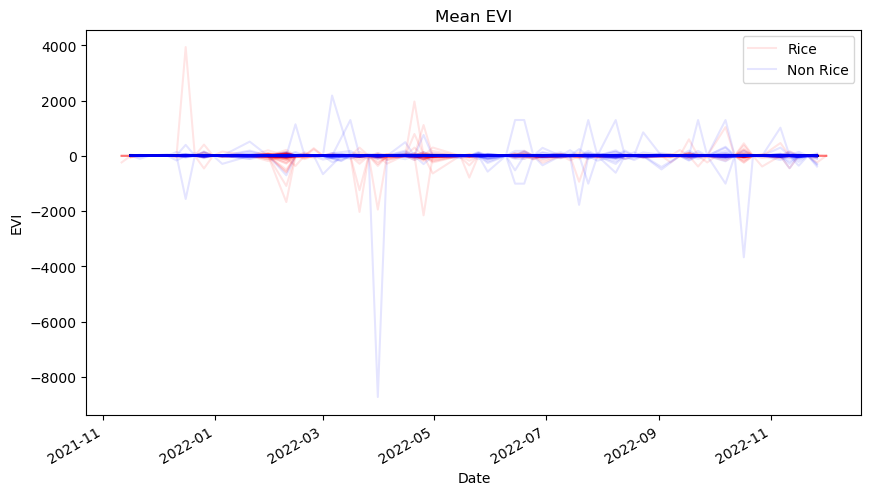

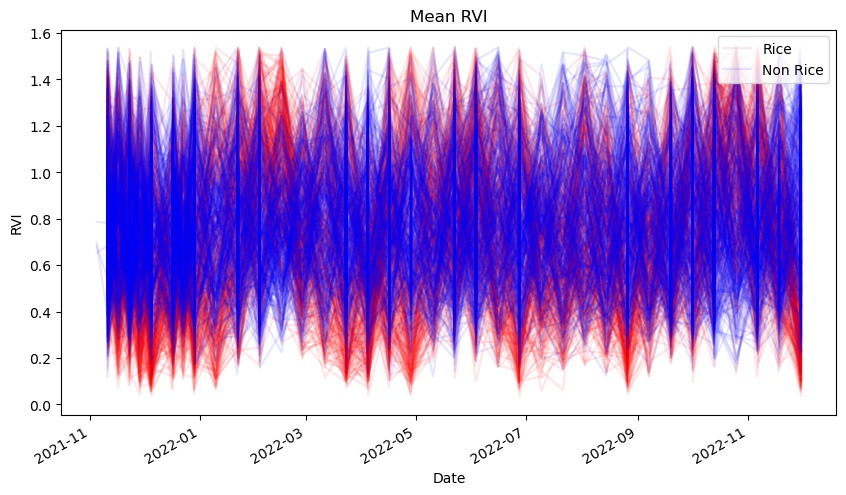

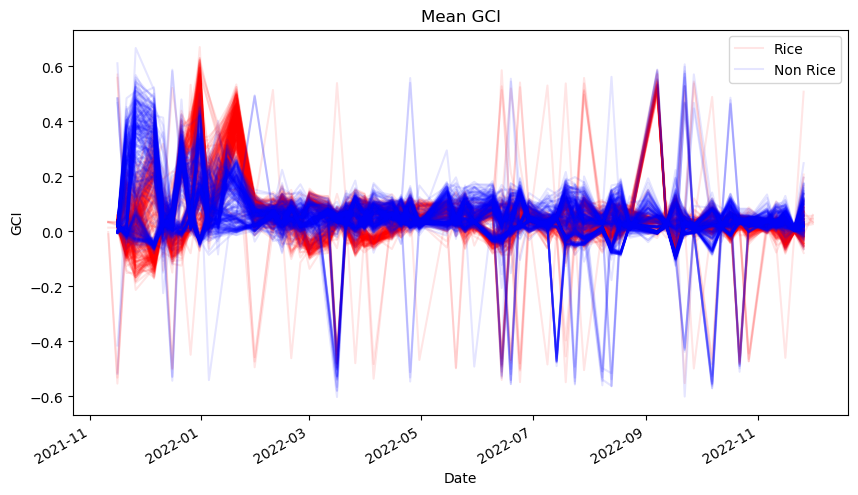

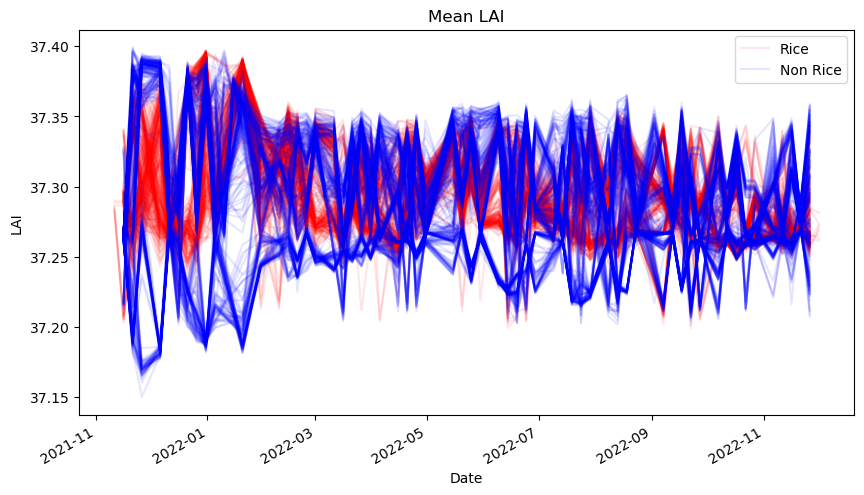

In [20]:
# Plot the outputs of viz_sen2
plot_time_series(crop_presence_data, "ndvi", "Mean NDVI", "NDVI")
plot_time_series(crop_presence_data, "savi", "Mean SAVI", "SAVI")
plot_time_series(crop_presence_data, "ndwi", "Mean NDWI", "NDWI")
plot_time_series(crop_presence_data, "evi", "Mean EVI", "EVI")
plot_time_series(crop_presence_data, "rvi", "Mean RVI", "RVI")
plot_time_series(crop_presence_data, "gci", "Mean GCI", "GCI")
plot_time_series(crop_presence_data, "lai", "Mean LAI", "LAI")
